# Sheer Heart Attack
### By: Jordan Crawford-O'Banner

Heart disease is the number one cause of death worldwide. As such, Driven Data has proposed a challenged to use a specific dataset from the Cleveland Heart Disease Database to try and create a machine learning model that can predict if a person has heart disease based upon certain factors. The data has 13 different health factors that are linked to heart disease. This is a classification problem because we are trying to determine only if they have heart disease or not. There are a few approaches to the problem that can be taking by using machine learning. This notebook will compare a few of those approaches.

The two approaches that we will be taking are by comparing a simple regression model and a deep learning model. Each of these approaches has their advantages and their disadvantages. The simple regression model has a lot of parts that can be analyzed in detail. I can tune and edit different parts of the model in order to make it more accurate, and we can easily test its accuracy. The deep learning model on the other hand, tend to be more accurate when they are done correctly. However, they can only be changed from the surface, and it can be very difficult to identify the inner workings of their algorithms.

First we must import the necessary functions and libraries

In [1]:
import jax.numpy as np
from jax import jit
import numpy.random as npr

import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

import thinkstats2
import pandas as pd

from jax import grad

import jax
from tqdm import tqdm_notebook as tqdmn

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso 
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Here I read the file that contains all of the data I will be working with. The indicators for heart disease are initially represented by 1 and 2. In order to more effectively build a model, I switch it so that 0 indicates not having heart disease and 2 indicates having heart disease.

In [2]:
data = pd.read_csv("./heartdata.csv")
data['heart_disease'].replace(1, 0, inplace=True)
data['heart_disease'].replace(2, 1, inplace=True)

The data shown below contains thirteen explanatory variables and one target variable. The variables include the age and sex of the respondent. The data corresponds people who are as male to 0 and people who are female to 1. There is also chest pain, which is recorded on a scale from 1 to 4. Other variables include resting blood pressure, serum cholestoral, if fasting blood pressure is greater 120 mg/dl , resting electrocardiograph results, maximum heart rate achieved, exercise induced angina, ST depression induced by exercise relative to rest, the slope of the peak exercise ST segment,  number of major vessels colored by flourosopy, and the status of the respondents thalamus. It is important to note that exercise induced angina, sex, and fasting blood pressure are all binary values, and the status of the respondents thalamus is a nominal value.

In [3]:
data.head()

,age,sex,chest_pain,rest_bp,serum_chol,fast_bs,rest_ecg,max_heart_rate,exercise_angina,oldpeak,peak_slope,flourosopy_vessels,thal,heart_disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


To increase the accuracy of our data we need to standardize the values that are  not binary or nominal. These values are on very different scales, so when the model attempts to compare them it will under utilize variables with smaller values and over utilize variables with larger values. After that I split the data into variables and the target or X and y, and I split those dataframes into training and test sets so I can evaluate my model

In [4]:
bigdata = data
bigdata["age"]=bigdata["age"]/max(bigdata["age"])
bigdata["rest_bp"]=bigdata["rest_bp"]/max(bigdata["rest_bp"])
bigdata["serum_chol"]=bigdata["serum_chol"]/max(bigdata["serum_chol"])
bigdata["max_heart_rate"]=bigdata["max_heart_rate"]/max(bigdata["max_heart_rate"])
bigdata["oldpeak"]=bigdata["oldpeak"]/max(bigdata["oldpeak"])
bigdata["flourosopy_vessels"]=bigdata["flourosopy_vessels"]/max(bigdata["flourosopy_vessels"])
y=pd.DataFrame(data["heart_disease"])
X= bigdata
X=X.drop("heart_disease",axis=1)
X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [5]:
data

,age,sex,chest_pain,rest_bp,serum_chol,fast_bs,rest_ecg,max_heart_rate,exercise_angina,oldpeak,peak_slope,flourosopy_vessels,thal,heart_disease
0,0.909091,1,4,0.650,0.570922,0,2,0.539604,0,0.387097,2,1.000000,3,1
1,0.870130,0,3,0.575,1.000000,0,2,0.792079,0,0.258065,2,0.000000,7,0
2,0.740260,1,2,0.620,0.462766,0,0,0.698020,0,0.048387,1,0.000000,7,1
3,0.831169,1,4,0.640,0.466312,0,0,0.519802,1,0.032258,2,0.333333,7,0
4,0.961039,0,2,0.600,0.476950,0,2,0.599010,1,0.032258,1,0.333333,3,0
5,0.844156,1,4,0.600,0.313830,0,0,0.693069,0,0.064516,1,0.000000,7,0
6,0.727273,1,3,0.650,0.453901,1,2,0.702970,1,0.096774,2,0.333333,6,1
7,0.766234,1,4,0.550,0.423759,0,2,0.702970,1,0.193548,2,0.333333,7,1
8,0.779221,1,4,0.700,0.519504,0,2,0.841584,0,0.193548,2,0.666667,7,1
9,0.818182,0,4,0.750,0.721631,0,2,0.762376,0,0.645161,2,1.000000,7,1


Here I perform a lasso regression to understand the most important values within the dataset.

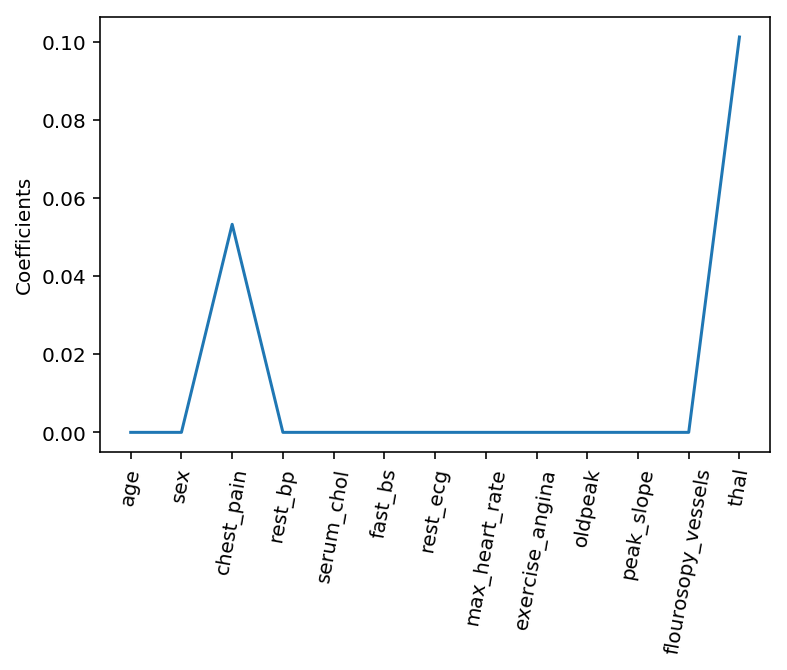

In [6]:
lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X, y).coef_
names = data.drop('heart_disease', axis=1).columns
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=80)
_ = plt.ylabel('Coefficients')
plt.show()

The graph shows that the most important variables are chest pain and the status of the respondents thalamus. The thalamus is the most influential variable here.

Next I will implement the deep learning model to predict if a respondent has heart disease. Within my model, I used two hidden layers. The first one uses tanh as the activation function. A tanh function is similar to a logistic function, but it keeps values between -1 and 1. I chose this function because it is similar to a logistic function, which means that it will put the model closer to the answer it is searching for. The second hidden layer uses a logistic function. I then filter both of these layers through a logistic function and arrive at the answer. The deep learning algorithm uses this model and performs gradient descent on it in order to minimize the loss.

In [7]:
def logistic(x):
    return 1 / (1 + np.exp(-x))
    
def logistic_loss(p, model, x, y):
    preds = model(p, x)
    return -np.mean(y * np.log(preds) + (1 - y) * np.log(1 - preds))

# Exercise: Define gradient of loss function.
dlogistic_loss = grad(logistic_loss)

def noise(size):
    return npr.normal(size=size)

# Exercise: Initialize parameters
params = dict()
params['w1'] = noise((13,6))
params['b1'] = noise((6,))
params['w2'] = noise((6,3))
params['b2'] = noise((3,))
params['w3'] = noise((3,1))
params['b3'] = noise((1,))

# Exercise: Write model together.
def model(p, x):
    
    a1 = np.tanh(np.dot(x,p['w1'])+p['b1'])
    # "a1" is the activation from layer 1
    
    # "a2" is the activation from layer 2
    a2 = logistic(np.dot(a1,p['w2'])+p['b2'])
    
    a3 = logistic(np.dot(a2,p['w3'])+p['b3'])
    return a3

# We do not need to rewrite the logistic loss: this is because it has been defined above already!

# Exercise: Write training loop.
losses = []
for i in tqdmn(range(10000)):
    grad_p = dlogistic_loss(params, model, X_train.values, y_train.values)
    for k, v in params.items():
        params[k] = params[k] - grad_p[k] * 0.01
    losses.append(logistic_loss(params, model, X_train.values, y_train.values))

A Jupyter Widget

/home/jobanner/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:144: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Here I plot the loss over each iteration that the gradient descent is preformed. As you can see the more iterations that are performed, the lower the loss gets until it eventually plateaus.

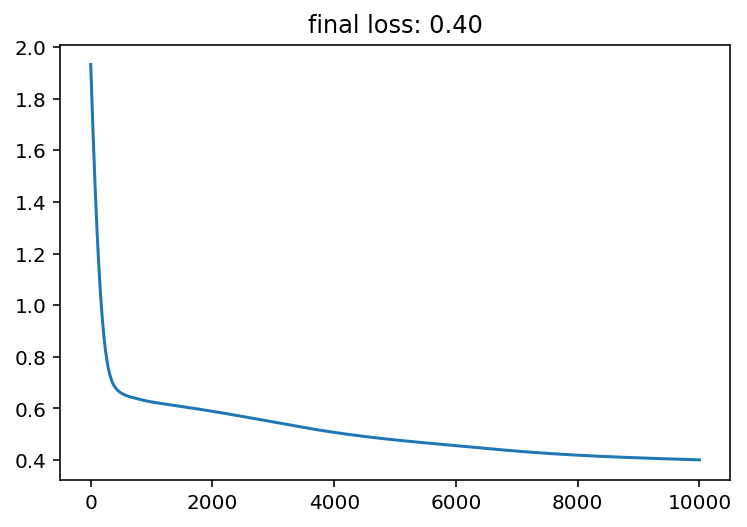

In [8]:
plt.plot(losses)
plt.title(f"final loss: {losses[-1]:.2f}")
plt.show()

Now that I have made the model as accurate as possible, I can use it on the test set to compute how accurate the model is. Here show the confusion matrix, and I create a heat map to show the confusion matrix in a more visual basis.

In [9]:
from sklearn.metrics import confusion_matrix

y_pred = model(params, X_test.values)
confusion_matrix(y_test, np.round(y_pred))

array([[38, 11],
       [ 9, 23]])

Text(33,0.5,'actual')

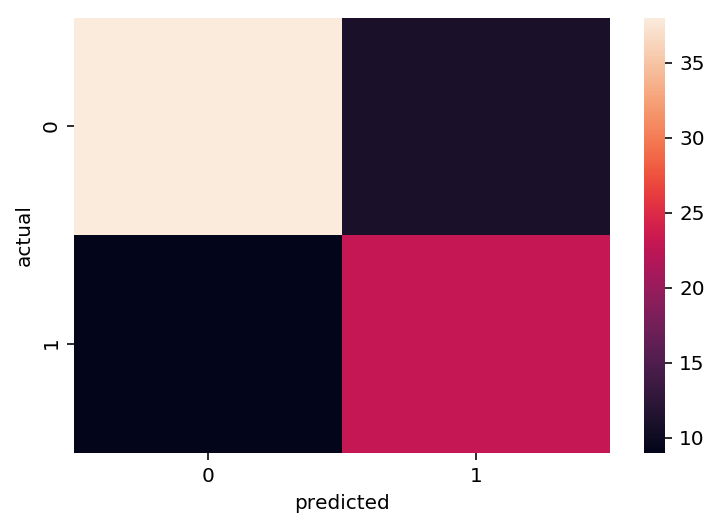

In [10]:
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, np.round(y_pred)))
plt.xlabel('predicted')
plt.ylabel('actual')

Now I will use the logistic regression model. Here I instantiate a logistic regression object and fit it to my training data. By doing this, I create a model that should accurately predict the testing data.

In [11]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train) 
y_pred = logreg.predict(X_test)
logreg.score(X_test,y_test)

/home/jobanner/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jobanner/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8765432098765432

The score shown there shows that the model predicted about 87% of the testing data correctly. Here is a confusion matrix in order to compare it to the deep learning model.

[[47  2]
 [ 8 24]]


Text(33,0.5,'actual')

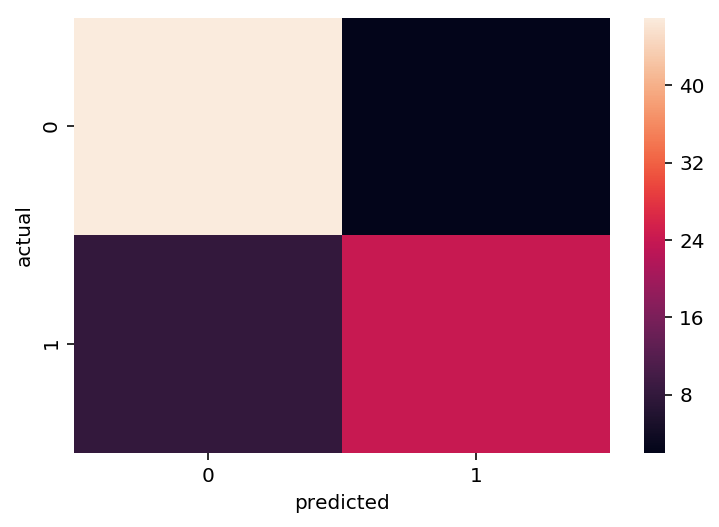

In [12]:
print(confusion_matrix(y_test, np.round(y_pred)))
sns.heatmap(confusion_matrix(y_test, np.round(y_pred)))
plt.xlabel('predicted')
plt.ylabel('actual')

The confusion matrix for this model can be seen to be somewhat less useful than the deep learning model. From the purple color of the bottom left corner, we can see that there is more false negatives within the logistic regression model than the deep learning model.

Next to further analyze the logistic regression model, I will plot a roc curve. The area under this curve shows the true positive rate of my model.

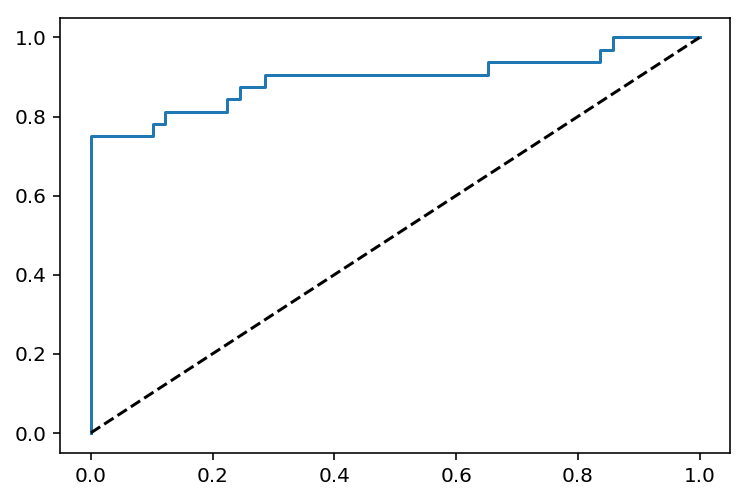

0.8960459183673469

In [13]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--') 
plt.show();
roc_auc_score(y_test,y_pred_prob)